# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 25.09.2022

Мягкий дедлайн: 23:59MSK 10.10.2022

Жесткий дедлайн: 23:59MSK 18.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [134]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [135]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [137]:
df = pd.read_csv('train.csv')
df.shape

(1458644, 11)

In [138]:
print('We do not need to worry about missing values.') if df.count().min() == df.shape[0] else print('oops')

We do not need to worry about missing values.


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [139]:
df = df.drop("dropoff_datetime", axis="columns")

In [140]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [141]:
df['pickup_datetime'] = pd.to_datetime(df.pickup_datetime)
df.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
trip_duration                  int64
dtype: object

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

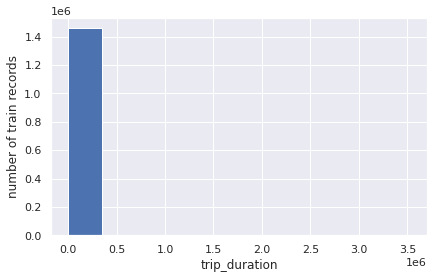

In [142]:
plt.hist(df['trip_duration'].values)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Несложно заметить, что наша целевая переменная **(среднее время поездки)** колеблется в среднем от 54 до 8103 секунд (в минутах 0.9..135). При этом, максимальное значение в часах - 979 (спасибо семинаристу за семинар).

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Нормальное распределение $\mathbf{N}(0, 1)$

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

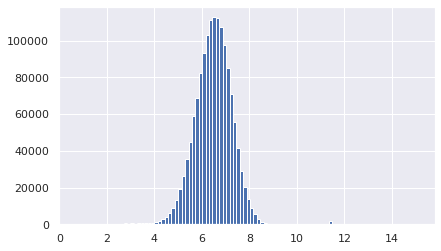

In [143]:
df['log_trip_duration'] = np.log1p(df['trip_duration'].values)
plt.hist(df['log_trip_duration'].values, bins=100)
df = df.drop('trip_duration', axis = 1)
plt.show()

In [144]:
print("В секундах:", np.exp(4), np.exp(9))
print("В минутах:", np.exp(4) / 60, np.exp(9) // 60)

В секундах: 54.598150033144236 8103.083927575384
В минутах: 0.9099691672190706 135.0


Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

Видим, что наименьшее количество поездок пришлось на 23 и 24 января 2016 года. Немного погуглив, нашёл следующую информацию: **снегопад в Нью-Йорке**.

https://nypost.com/2016/01/22/

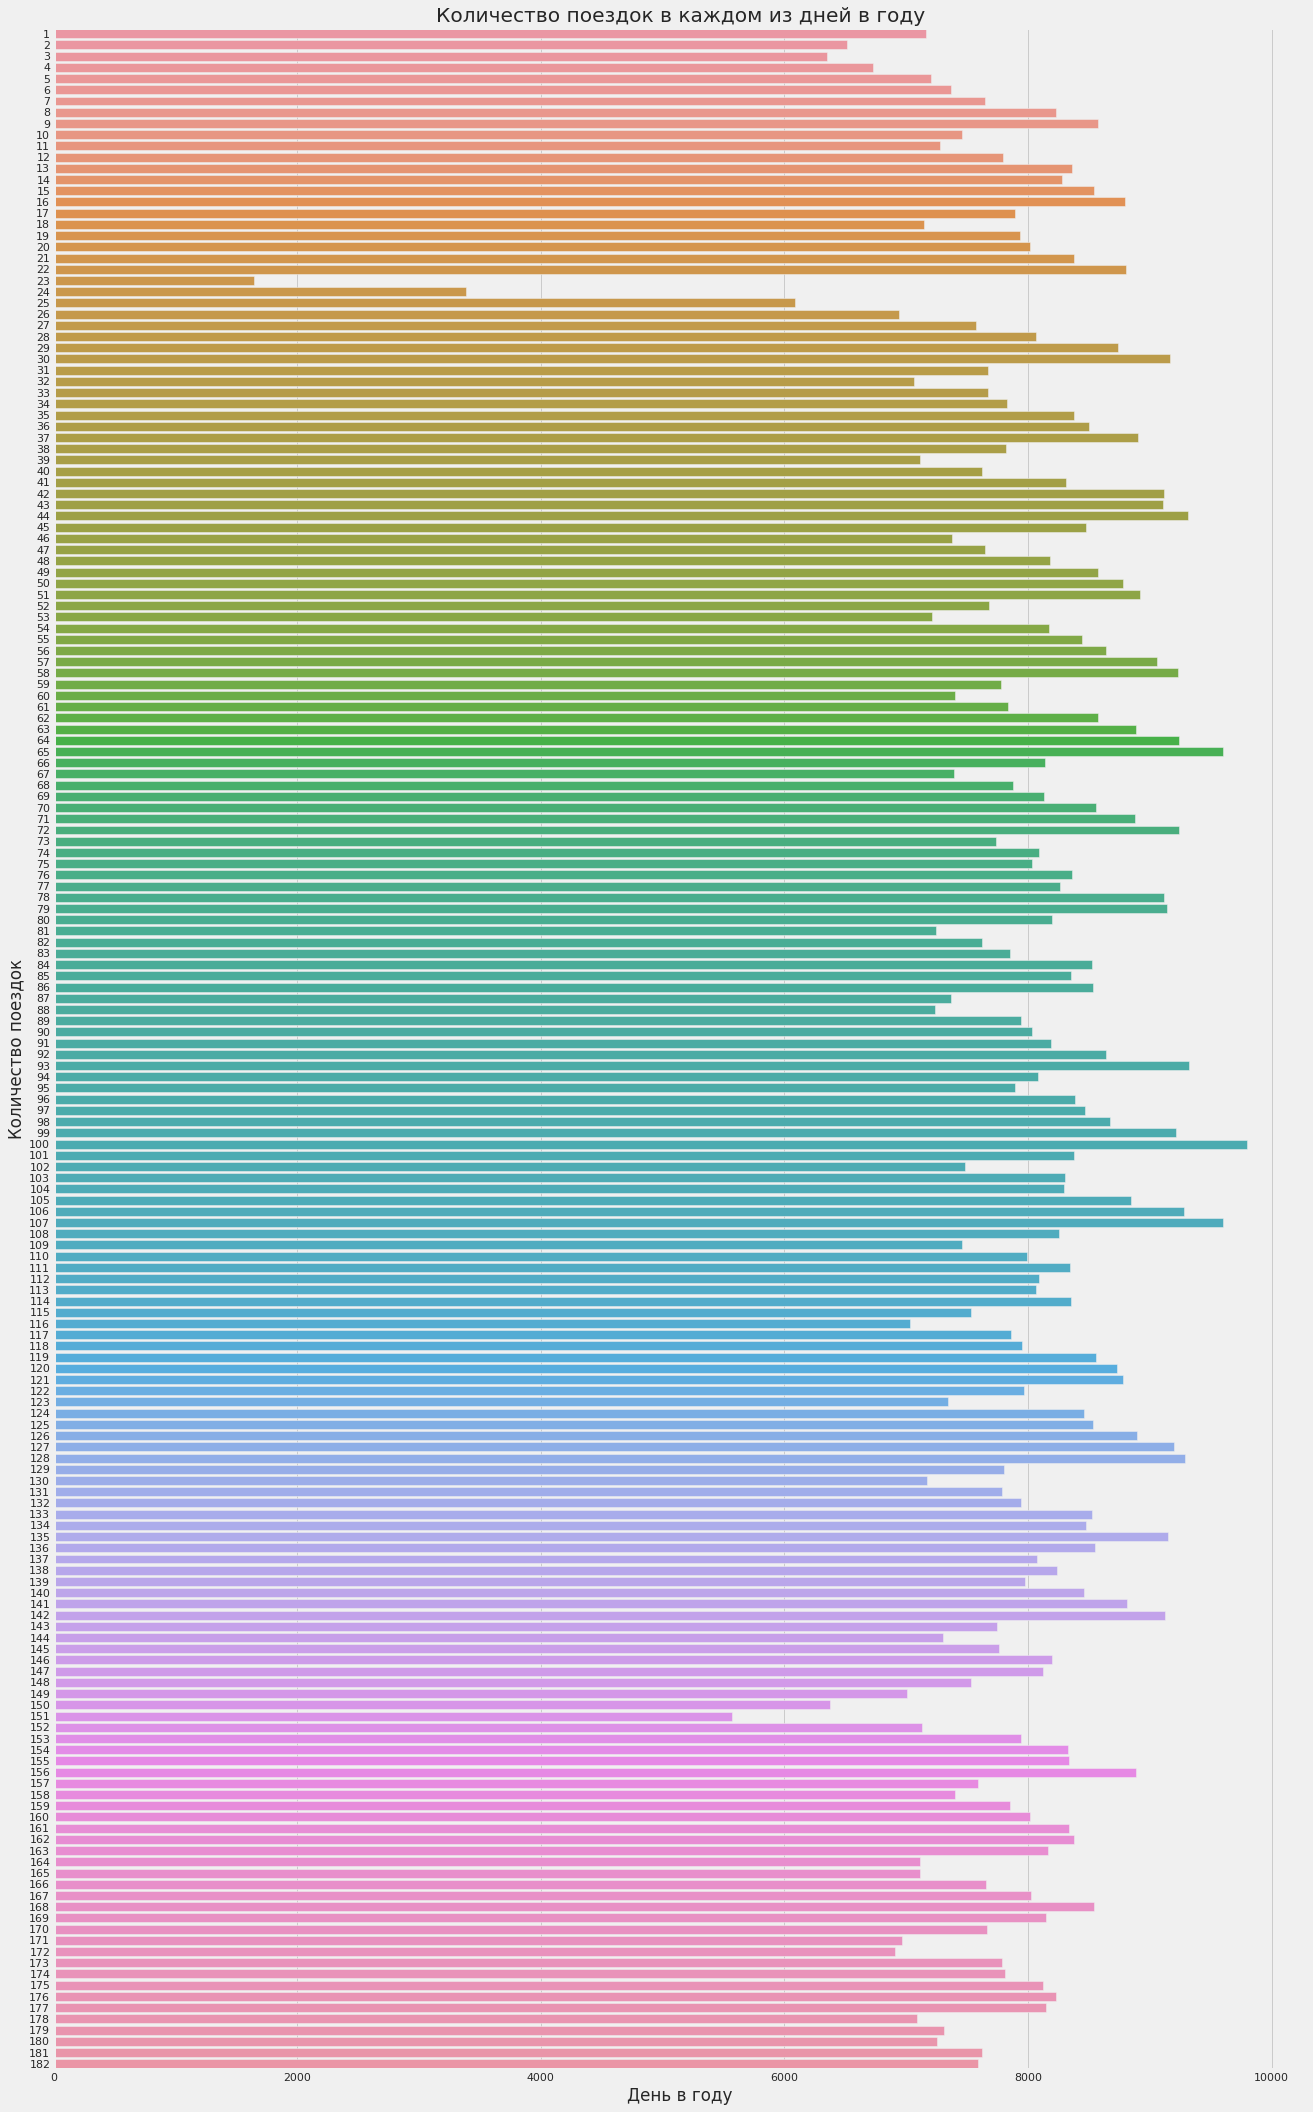

In [145]:
plt.style.use(['fivethirtyeight'])
plt.rcParams['figure.figsize']=(20, 35)

sns.countplot(y = df['pickup_datetime'].dt.dayofyear, data=df)
plt.title('Количество поездок в каждом из дней в году')
plt.ylabel('Количество поездок')
plt.xlabel('День в году')

plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [146]:
df['pickup_dt_wht_hours'] = df['pickup_datetime'].dt.date
df.groupby(df['pickup_dt_wht_hours']).size().reset_index(name='count')

,pickup_dt_wht_hours,count
0,2016-01-01,7162
1,2016-01-02,6512
2,2016-01-03,6353
3,2016-01-04,6725
4,2016-01-05,7204
...,...,...
177,2016-06-26,7084
178,2016-06-27,7311
179,2016-06-28,7253
180,2016-06-29,7623


In [147]:
df['pickup_dt_wht_hours'] = df['pickup_datetime'].dt.date
df_date_prom = df.groupby(df['pickup_dt_wht_hours']).size().reset_index(name='count')
df_date_prom.sort_values(by=['count'])[0:10]

,pickup_dt_wht_hours,count
22,2016-01-23,1648
23,2016-01-24,3383
150,2016-05-30,5570
24,2016-01-25,6084
2,2016-01-03,6353
149,2016-05-29,6372
1,2016-01-02,6512
3,2016-01-04,6725
171,2016-06-20,6910
25,2016-01-26,6941


Видим, что наименьшее количество поездок пришлось на 23 и 24 января 2016 года. Немного погуглив, нашёл следующую информацию: **снегопад в Нью-Йорке**.

https://nypost.com/2016/01/22/

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


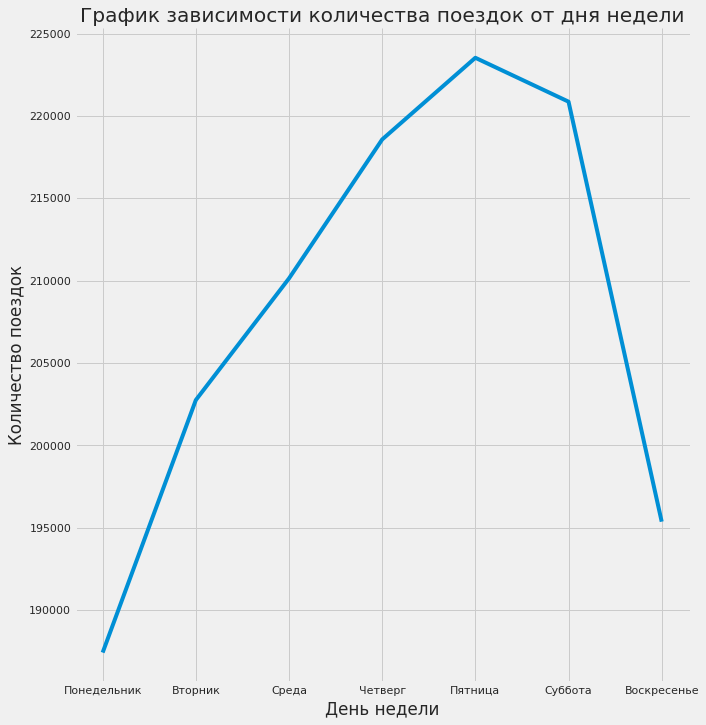

In [148]:
plt.style.use(['fivethirtyeight'])

df1 = df[['pickup_datetime', 'id']]
df1.loc[:, 'pickup_datetime'] = df1['pickup_datetime'].dt.dayofweek
df1.loc[:, 'id'] = df['pickup_datetime']
df1 = df1.groupby(df1['pickup_datetime']).size().reset_index(name='count')

names_of_days_of_the_week = {0:'Понедельник',
       1:'Вторник',
       2:'Среда',
       3:'Четверг',
       4:'Пятница',
       5:'Суббота',
       6:'Воскресенье'}

df1['pickup_datetime'] = df1['pickup_datetime'].replace(names_of_days_of_the_week)


sns.relplot(x = df1['pickup_datetime'],
            y = df1['count'],
            height=10,
            kind='line')

plt.title('График зависимости количества поездок от дня недели')
plt.ylabel('Количество поездок')
plt.xlabel('День недели')

plt.show()

### Реализуем график зависимости количества поездок от часов в сутках

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


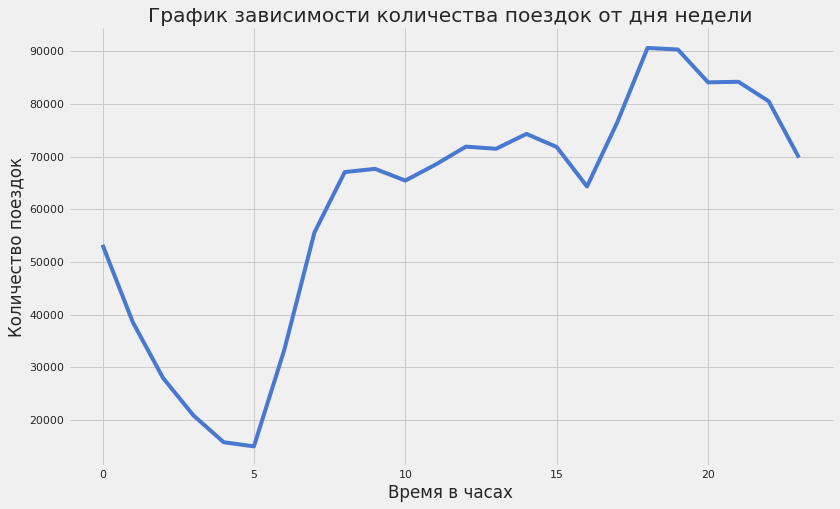

In [149]:
plt.style.use(['seaborn-muted'])

df1 = df[['pickup_datetime', 'id']]
df1.loc[:, 'pickup_datetime'] = df1['pickup_datetime'].dt.hour
df1.loc[:, 'id'] = df['pickup_datetime']
df1 = df1.groupby(df1['pickup_datetime']).size().reset_index(name='count')

sns.relplot(x = df1['pickup_datetime'], y = df1['count'], height=7, aspect=1.7, kind='line')

plt.title('График зависимости количества поездок от дня недели')
plt.ylabel('Количество поездок')
plt.xlabel('Время в часах')

plt.show()

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

hue - https://seaborn.pydata.org/generated/seaborn.relplot.html

groupby - https://stackoverflow.com/questions/17679089/pandas-dataframe-groupby-two-columns-and-get-counts

replace - https://pandas.pydata.org/docs/reference/api/pandas.Series.replace.html

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


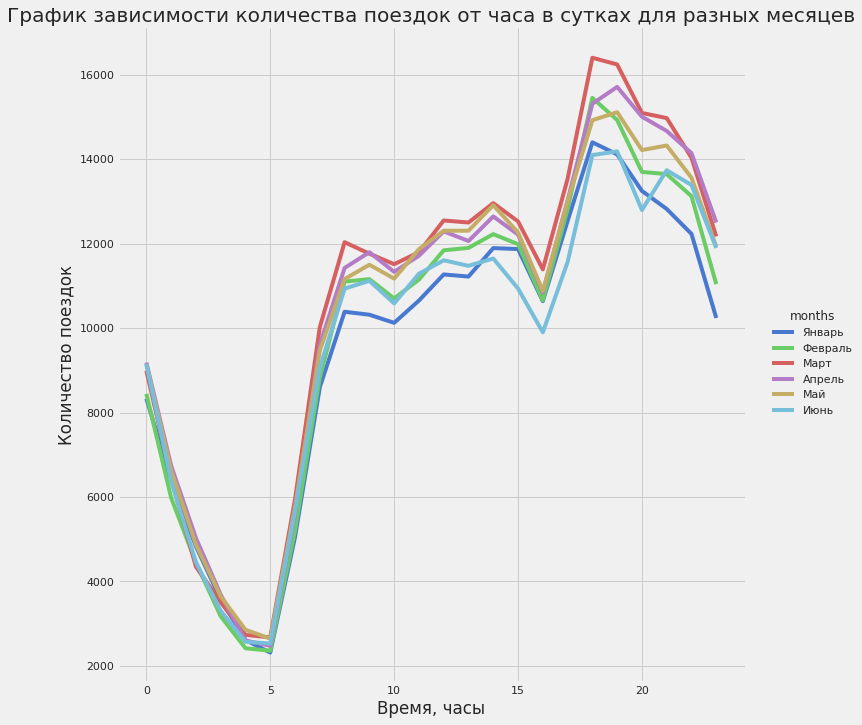

In [150]:
plt.style.use(['seaborn-muted'])

df2_month = df['pickup_datetime'].dt.month
df2_hour = df['pickup_datetime'].dt.hour
df2_count = df['pickup_datetime'].groupby([df2_hour, df2_month]).count()
df2_overall = df2_count.index.to_frame(name=['hours', 'months'], index=False)
df2_count.reset_index(drop=True, inplace=True)
df2_overall['trips'] = df2_count

m_s = {1:'Январь',
       2:'Февраль',
       3:'Март',
       4:'Апрель',
       5:'Май',
       6:'Июнь'}

df2_overall['months'] = df2_overall['months'].replace(m_s)

sns.relplot(df2_overall['hours'],
            df2_overall['trips'],
            hue=df2_overall['months'],
            height=10,
            kind='line')

plt.title('График зависимости количества поездок от часа в сутках для разных месяцев')
plt.ylabel('Количество поездок')
plt.xlabel('Время, часы')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


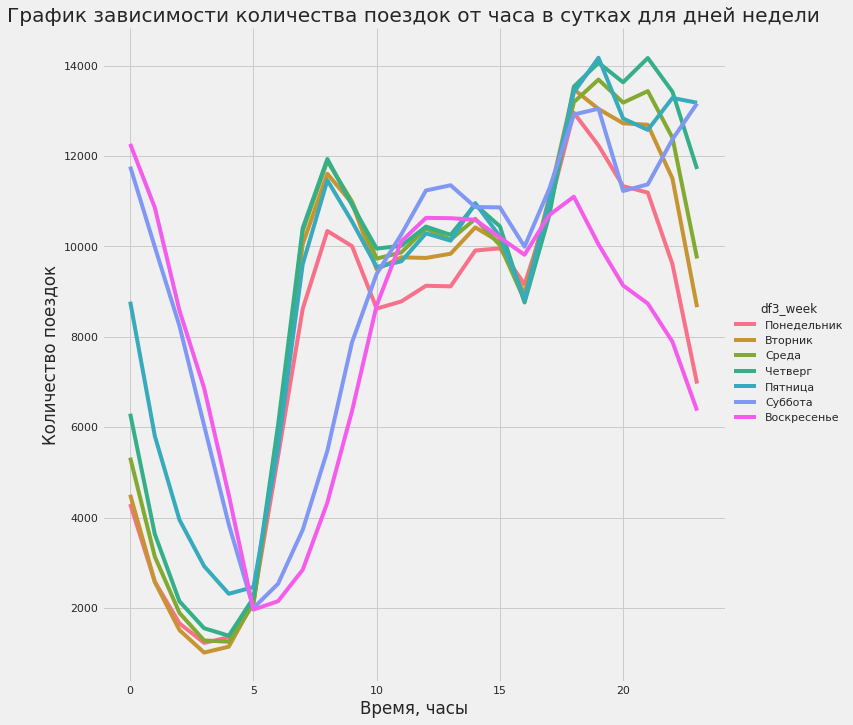

In [151]:
plt.style.use(['seaborn-muted'])

df3_week = df['pickup_datetime'].dt.dayofweek
df3_hour = df['pickup_datetime'].dt.hour
df3_count = df['pickup_datetime'].groupby([df3_hour, df3_week]).count()
df3_overall = df3_count.index.to_frame(name=['df3_hour', 'df3_week'], index=False)
df3_count.reset_index(drop=True, inplace=True)
df3_overall['trips'] = df3_count
df3_overall['df3_week'] = df3_overall['df3_week'].replace(names_of_days_of_the_week)

sns.relplot(df3_overall['df3_hour'],
            df3_overall['trips'],
            hue=df3_overall['df3_week'],
            height=10,
            kind='line')

plt.title('График зависимости количества поездок от часа в сутках для дней недели')
plt.ylabel('Количество поездок')
plt.xlabel('Время, часы')
plt.show()

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?
---------------------------------------------------------
Несложно заметить, что наибольшее количество поезжок приходится преимущественно на утреннее и вечерное время, а именно, около 7 утра и 18-19 вечера. То есть среднее время отъезда и приезда на работу. 

Видим, что количество рейсов обратно пропорционально порядку дней недели, т.е. в воскресенье люди больше сидят дома).

В июне и январе наблюдается спад количества рейсов, возможно из-за средней температуры. Т.е. весной климат оптимальный - люди больше катаются.

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

train_test_split - https://pythonru.com/baza-znanij/sklearn-train-test-split

https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem02-sklearn-linregr.ipynb

In [152]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['log_trip_duration'])
y = df['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 10)

Посмотрели на значения целевой переменной:


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


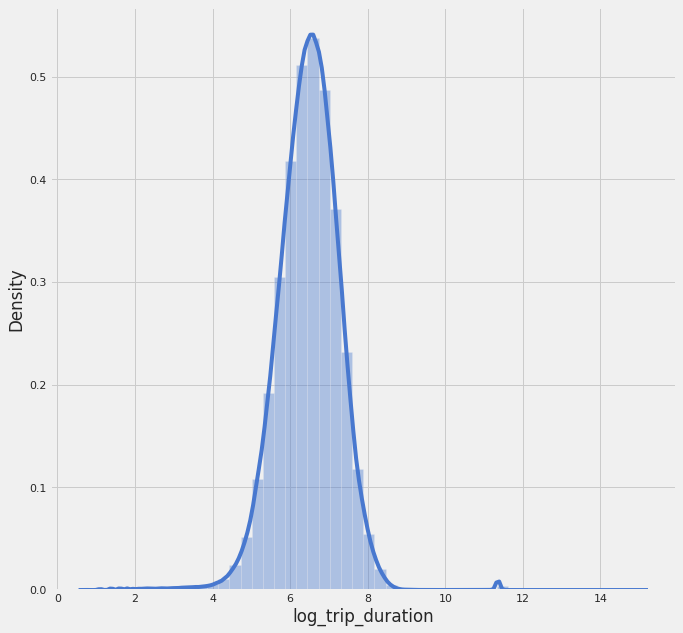

In [203]:
plt.style.use(['seaborn-muted'])

plt.rcParams['figure.figsize']=(10, 10)
sns.distplot(y_train)

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   id                   1458644 non-null  object        
 1   vendor_id            1458644 non-null  int64         
 2   pickup_datetime      1458644 non-null  datetime64[ns]
 3   passenger_count      1458644 non-null  int64         
 4   pickup_longitude     1458644 non-null  float64       
 5   pickup_latitude      1458644 non-null  float64       
 6   dropoff_longitude    1458644 non-null  float64       
 7   dropoff_latitude     1458644 non-null  float64       
 8   store_and_fwd_flag   1458644 non-null  object        
 9   log_trip_duration    1458644 non-null  float64       
 10  pickup_dt_wht_hours  1458644 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 122.4+ MB


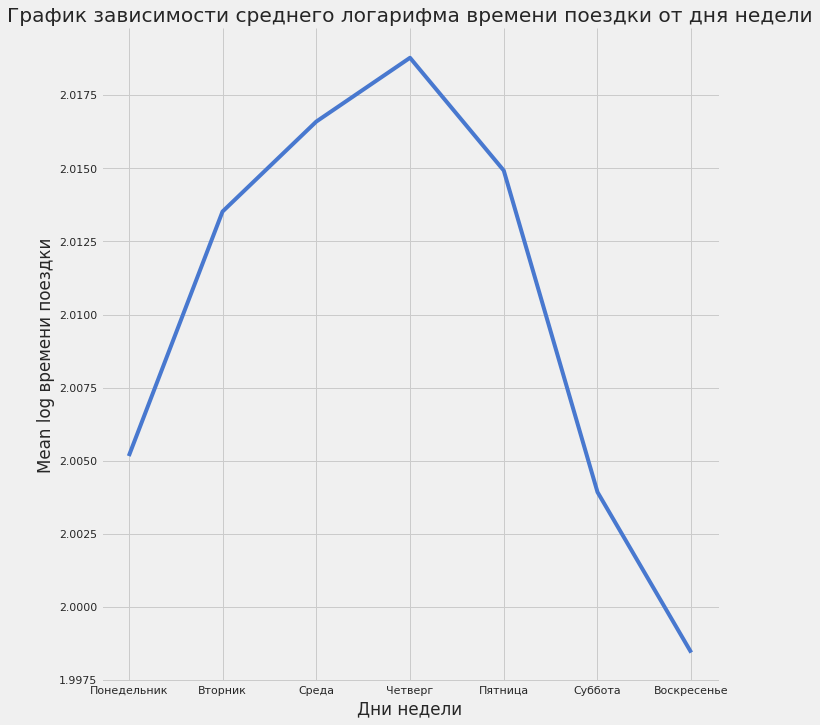

In [155]:
plt.style.use(['seaborn-muted'])

df_train = X_train.join(y_train)
df_log_2 = df_train.groupby([df3_week]).mean()


sns.relplot(
    x = names_of_days_of_the_week.values(),
    y = np.log1p(df_log_2['log_trip_duration']),
    height=10,
    kind="line",
    )

plt.title('График зависимости среднего логарифма времени поездки от дня недели')
plt.xlabel('Дни недели')
plt.ylabel('Mean log времени поездки')
plt.show()

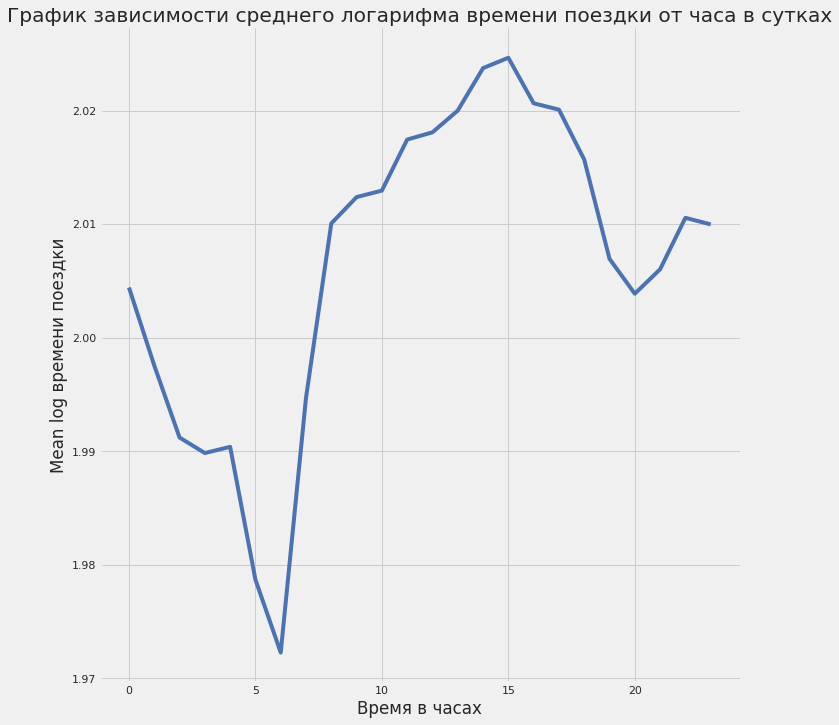

In [202]:
plt.style.use(['fivethirtyeight'])

df_log_2 = df_train.groupby([df3_hour]).mean()


sns.relplot(
    x = np.arange(0, 24),
    y = np.log1p(df_log_2['log_trip_duration']),
    height=10,
    kind="line",
    color="b",
    )

plt.title('График зависимости среднего логарифма времени поездки от часа в сутках')
plt.xlabel('Время в часах')
plt.ylabel('Mean log времени поездки')
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

***По рекомендации моего семинариста создаю ещё один график относительной дней в году.***

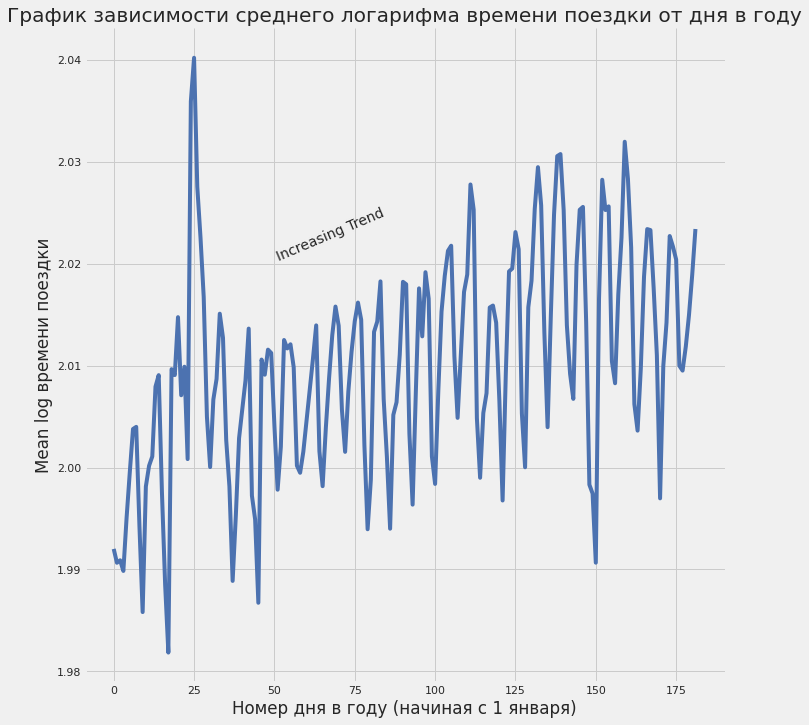

In [157]:
plt.style.use(['fivethirtyeight'])

df_log_2 = df_train.groupby(df['pickup_datetime'].dt.dayofyear).mean()

sns.relplot(
    x = np.arange(0, 182),
    y = np.log1p(df_log_2['log_trip_duration']),
    height=10,
    kind="line",
    color="b",
    )

plt.annotate('Increasing Trend',
            xy = (50, 2.02),
            rotation= 23,
            va = 'bottom',
            ha = 'left')


plt.title('График зависимости среднего логарифма времени поездки от дня в году')
plt.xlabel('Номер дня в году (начиная с 1 января)')
plt.ylabel('Mean log времени поездки')
plt.show()

**Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему?**

Не особо, т.к. log сильно меняет границы (дозволенного). То есть разница между максимумом и минимумом будет более выражена.

**Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит?**
Видим, что 22-23 января среднее время поездок (кол-ва поездок) достигает своего локального минимума. Как выясняли ранее - снегопад в Нью-Йорке.

**Наблюдаете ли вы какой-нибудь тренд на графике зависимости log_trip_duration от номера дня в году?**

Бычий тренд (up! up! up!)



Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [158]:
df['pickup_datetime']

0         2016-03-14 17:24:55
1         2016-06-12 00:43:35
2         2016-01-19 11:35:24
3         2016-04-06 19:32:31
4         2016-03-26 13:30:55
                  ...        
1458639   2016-04-08 13:31:04
1458640   2016-01-10 07:35:15
1458641   2016-04-22 06:57:41
1458642   2016-01-05 15:56:26
1458643   2016-04-05 14:44:25
Name: pickup_datetime, Length: 1458644, dtype: datetime64[ns]

In [159]:
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month
df['hour'] = df['pickup_datetime'].dt.hour
df['is_anomaly_day_1'] = 0
df['is_anomaly_day_2'] = 0

df.loc[df['pickup_datetime'].dt.dayofyear == 22, "is_anomaly_day_1"] = 1
df.loc[df['pickup_datetime'].dt.dayofyear == 23, "is_anomaly_day_1"] = 1

df['day_of_year'] = df['pickup_datetime'].dt.dayofyear
# df.groupby(df['pickup_dt_wht_hours']).size().reset_index(name='count').head(30)



Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

Помним, что на примере задачи со стоимостью квартиры **район** является **категориальным** признаком, т.к. **его значения нельзя сравнивать в соотношении больше/меньше, складывать/вычитать.**

К **категориальным** можно отнести - день недели, месяц, является ли период аномальным, номер дня в году (±, т.к. нельзя сравнить)

**Численные** - час.

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [160]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['log_trip_duration'])
y = df['log_trip_duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 10)

df.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,pickup_dt_wht_hours,day_of_week,month,hour,is_anomaly_day_1,is_anomaly_day_2,day_of_year
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,2016-03-14,0,3,17,0,0,74
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,2016-06-12,6,6,0,0,0,164
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,2016-01-19,1,1,11,0,0,19
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,2016-04-06,2,4,19,0,0,97
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,2016-03-26,5,3,13,0,0,86


In [161]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem02-sklearn-linregr.ipynb

Часть 3

In [162]:
categorical_features = X_train[['day_of_week',
                                'month',
                                'is_anomaly_day_1',
                                'is_anomaly_day_2']].columns

numeric_features = X_train[['hour', 'day_of_year']].columns

In [163]:
df = df.dropna(axis='columns')

In [164]:
df.isna().sum()

id                     0
vendor_id              0
pickup_datetime        0
passenger_count        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      0
dropoff_latitude       0
store_and_fwd_flag     0
log_trip_duration      0
pickup_dt_wht_hours    0
day_of_week            0
month                  0
hour                   0
is_anomaly_day_1       0
is_anomaly_day_2       0
day_of_year            0
dtype: int64

In [165]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

ridge_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = ridge_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)


print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7912


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [166]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [167]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [168]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

Два аэропорта.

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [169]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


df.loc[:, 'haversine'] = haversine_array(
    df['pickup_latitude'].values,
    df['pickup_longitude'].values,
    df['dropoff_latitude'].values,
    df['dropoff_longitude'].values)

In [170]:
df.head(5)

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,pickup_dt_wht_hours,day_of_week,month,hour,is_anomaly_day_1,is_anomaly_day_2,day_of_year,haversine
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,2016-03-14,0,3,17,0,0,74,1.498521
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,2016-06-12,6,6,0,0,0,164,1.805507
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,2016-01-19,1,1,11,0,0,19,6.385098
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,2016-04-06,2,4,19,0,0,97,1.485498
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,2016-03-26,5,3,13,0,0,86,1.188588


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [171]:
df['log_haversine'] = np.log1p(df['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [172]:
corrmat = df[['haversine', 'log_haversine', 'log_trip_duration']].corr()
corrmat

,haversine,log_haversine,log_trip_duration
haversine,1.000000,0.844501,0.573595
log_haversine,0.844501,1.000000,0.749882
log_trip_duration,0.573595,0.749882,1.000000


0.74 > 0.57

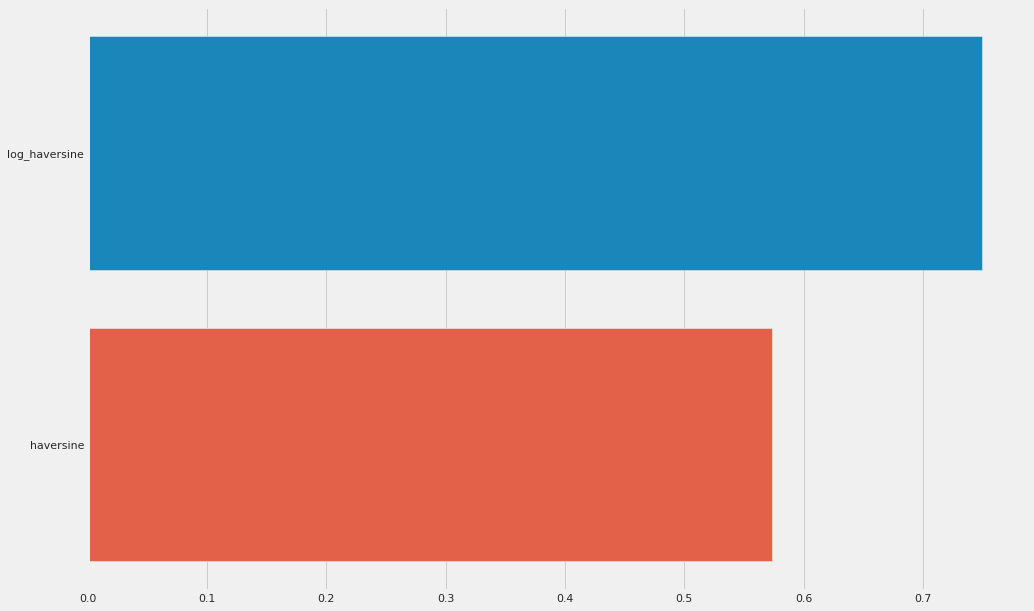

In [173]:
correlations = df[['haversine', 'log_haversine']].corrwith(df['log_trip_duration']).sort_values(ascending=False)

plt.rcParams['figure.figsize']=(10, 10)
plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


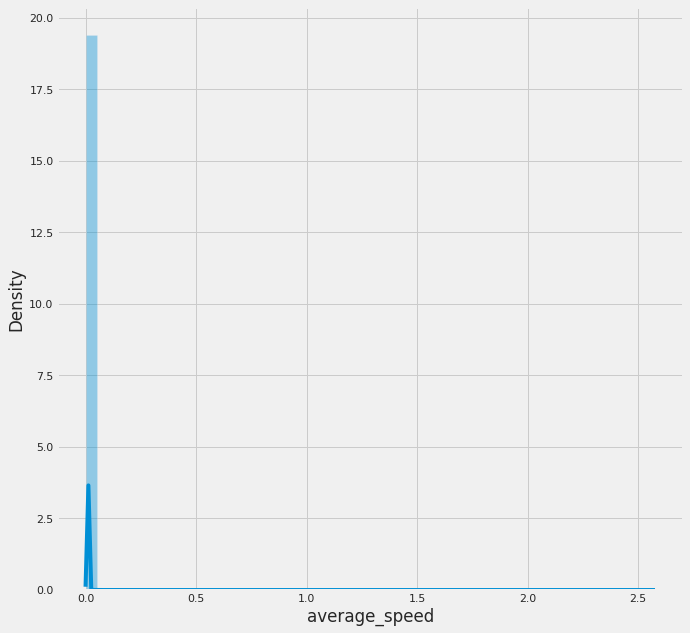

In [174]:
middle_speed = df['haversine'] / np.expm1(df['log_trip_duration'])
df['average_speed'] = middle_speed
# plt.hist(df['average_speed'])
plt.rcParams['figure.figsize']=(10, 10)
sns.distplot(df['average_speed'])

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [175]:
df['average_speed'].describe()

count    1.458644e+06
mean     4.006447e-03
std      4.160423e-03
min      0.000000e+00
25%      2.533687e-03
50%      3.553327e-03
75%      4.956920e-03
max      2.576344e+00
Name: average_speed, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


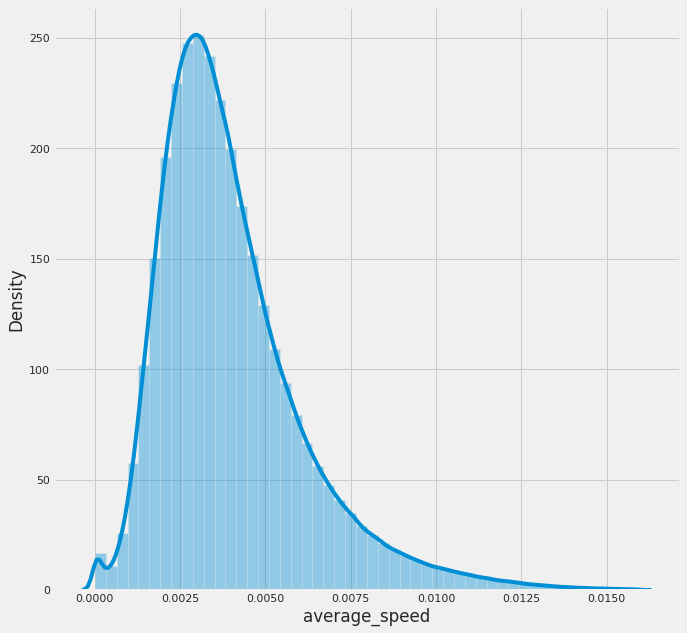

In [176]:
sns.distplot(df[(df['average_speed'] > 0.000001) & (df['average_speed'] < 15.956920e-03)]['average_speed'])

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

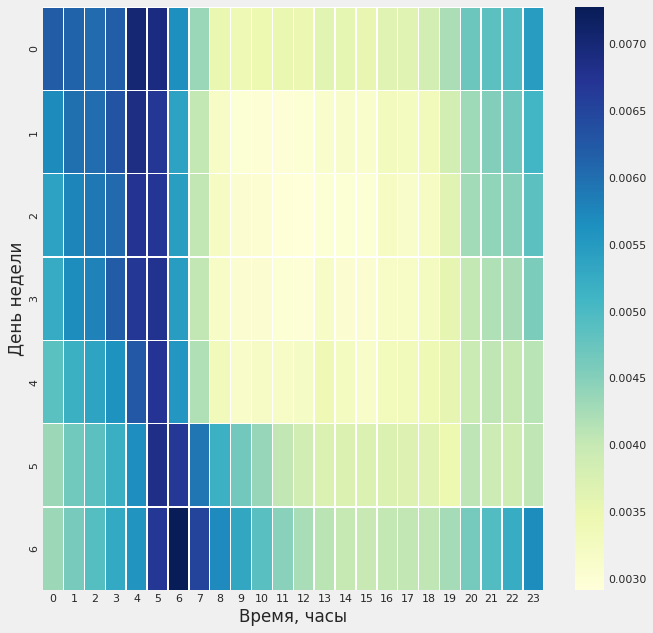

In [177]:
df_heatmap = df.pivot_table(
                        index='day_of_week', 
                        columns='hour', 
                        values='average_speed',
                        aggfunc=np.mean,
                        )
sns.heatmap(df_heatmap, linewidths=.5, cmap="YlGnBu")

names_of_days_of_the_week = {0:'Понедельник',
           1:'Вторник',
           2:'Среда',
           3:'Четверг',
           4:'Пятница',
           5:'Суббота',
           6:'Воскресенье'}


plt.xlabel('Время, часы')
plt.ylabel('День недели')
plt.show()

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?


Мы считали среднюю скорость относительно отношений двух столбцов. То есть зависимая величина от двух других. Можем получить утечку данных, следовательно, риск переобученности возрастает.

In [178]:
# df = df.drop(columns = 'average_speed')

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Минимальная в период с 9 утра до 18 вечера. Максимальная скорость в период с 4 до 6 утра.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [179]:
df['in_traffic_jam'] = 0
df['not_in_traffic_jam'] = 0

true_false_dict = {0: False, 1: True}

# период когда пробки есть -> поездка совершается в период пробок
df.loc[((df['day_of_week'] < 5) & ((df['hour'] > 6) & (df['hour'] < 22))) |
       ((df['day_of_week'] > 4) & ((df['hour'] > 10) & (df['hour'] < 19))),
       'in_traffic_jam'] = 1


# период когда пробок нет -> поездка совершается в период свободных дорог
df.loc[((df['day_of_week'] < 5) & ((df['hour'] < 7) & (df['hour'] > 22))) |
       ((df['day_of_week'] > 4) & ((df['hour'] > 1) & (df['hour'] < 10))) |
       ((df['day_of_week'] == 6) & (df['hour'] > 20)),
       "not_in_traffic_jam"] = 1


df['in_traffic_jam'] = df['in_traffic_jam'].replace(true_false_dict)
df['not_in_traffic_jam'] = df['not_in_traffic_jam'].replace(true_false_dict)

Поездка совершается без пробок + поездка совершается в период свободных дорог. Следовательно, надо просто понять, в какое время (день недели + время в часах) есть пробки, а в какие их нет.

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [180]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

In [181]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [182]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # your code here
        pass
    
    def show_map(self):
        # you may want to visualize cells
        pass
    
    def fit(self, X=None, y=None):
        # your code here
        return self

    def transform(self, X, y=None):
        # your code here
        return X

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [183]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [184]:
print('vendor_id -> ', df['vendor_id'].nunique())
print('passenger_count -> ', df['passenger_count'].nunique())
print('store_and_fwd_flag -> ', df['store_and_fwd_flag'].nunique())

vendor_id ->  2
passenger_count ->  10
store_and_fwd_flag ->  2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

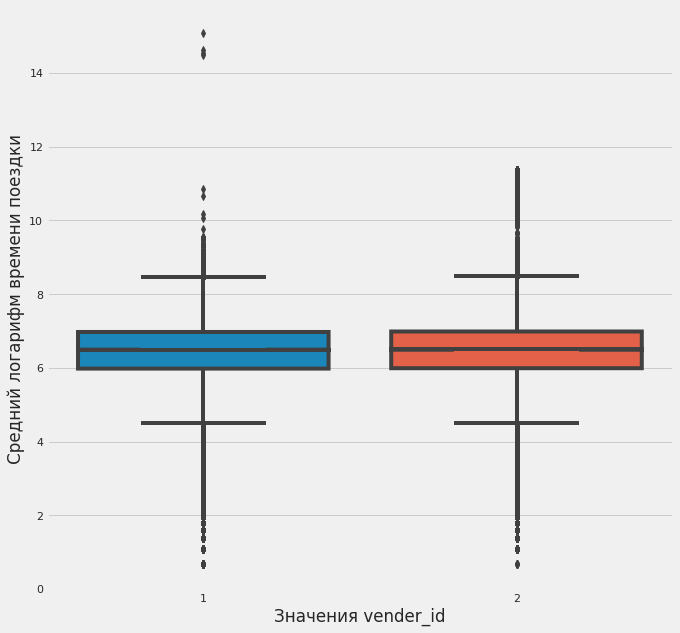

In [185]:
sns.boxplot(x = df['vendor_id'],
            y = df['log_trip_duration'],
            notch = True)

plt.ylabel('Средний логарифм времени поездки')
plt.xlabel('Значения vender_id')
plt.show()

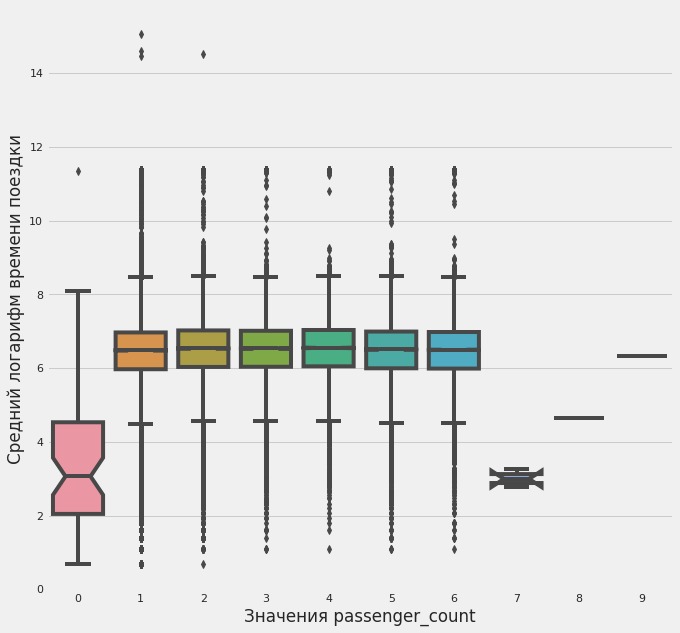

In [186]:
sns.boxplot(x = df['passenger_count'],
            y = df['log_trip_duration'],
            notch = True)

plt.ylabel('Средний логарифм времени поездки')
plt.xlabel('Значения passenger_count')

plt.show()

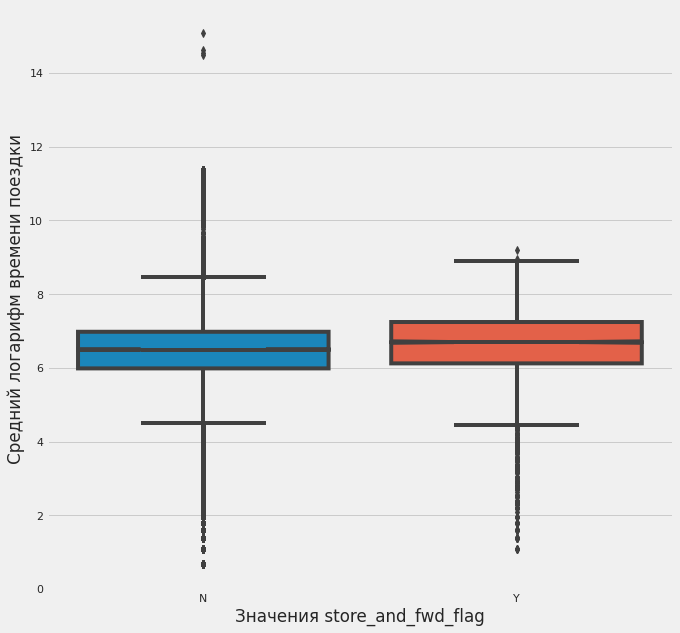

In [187]:
sns.boxplot(x = df['store_and_fwd_flag'],
            y = df['log_trip_duration'],
            notch = True)

plt.ylabel('Средний логарифм времени поездки')
plt.xlabel('Значения store_and_fwd_flag')

plt.show()

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [188]:
df.loc[df['vendor_id'] == 2, 'vendor_id'] = 0
df.loc[df['store_and_fwd_flag'] == 'N', 'store_and_fwd_flag'] = 0
df.loc[df['store_and_fwd_flag'] == 'Y', 'store_and_fwd_flag'] = 1

df['store_and_fwd_flag']

0          0
1          0
2          0
3          0
4          0
          ..
1458639    0
1458640    0
1458641    0
1458642    0
1458643    0
Name: store_and_fwd_flag, Length: 1458644, dtype: object

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Ввиду сильного разброса относительно медианы ящика с усами - думаю, что нет.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [189]:
categorical_features = X_train[['day_of_week',
                                'month',
                                'is_anomaly_day_1',
                                'is_anomaly_day_2',
                                'store_and_fwd_flag',]].columns

numeric_features = X_train[['hour', 'day_of_year', 'vendor_id', 'passenger_count']].columns

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7908


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [190]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [191]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [192]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [193]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [194]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [195]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [196]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [197]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

In [198]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [199]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [200]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.